# Event-based Constellation Example

This notebook illustrates how to run many PASEOS instances in parellel to model a constellation in low-Earth orbit (LEO). 

First, let's import all necessary modules

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import sys 
sys.path.append("../..")

import pykep as pk
import paseos
from paseos import ActorBuilder, SpacecraftActor, GroundstationActor
paseos.set_log_level("INFO")

22:24:27|PASEOS-DEBUG| Setting LogLevel to DEBUG
22:24:27|PASEOS-DEBUG| Loaded module.


## Constellation setup

In addition to the code in this notebook, we use a simple function that automatically computes the orbits of a [Walker Constellation](https://en.wikipedia.org/wiki/Satellite_constellation#Walker_Constellation) for us. It allows us to only specify a few parameters to get started.

For illustrative purposes our constellation will consist of only four satellites in LEO and one communication satellite in GEO. Feel free to change the numbers to try out different setups.

In [2]:
from get_constellation import get_constellation
altitude = 400 * 1000 # Constellation attitude above the Earth's ground
inclination = 30.0 # inclination of each orbital plane
nPlanes = 1 # the number of orbital planes (see linked wiki article)
nSats = 4 # the number of satellites per orbital plane
t0 = pk.epoch_from_string("2022-Oct-27 21:00:00") # the starting date of our simulation

# Compute orbits of LEO satellites
planet_list,sats_pos_and_v = get_constellation(altitude,inclination,nSats,nPlanes,t0)

# Compute orbit of GEO communications satellite
comms_sat,comm_sat_pos_and_v = get_constellation(30000*1000,0,1,1,t0)

Added 4 planets
Computing positions and velocities
Added 1 planets
Computing positions and velocities


Let's briefly plot our satellite orbits for illustrative purposes. We use [pykep's plotting features](https://esa.github.io/pykep/documentation/orbitplots.html) for that.

Note that angles aren't to scale in pykep plots.

<Axes3DSubplot:>

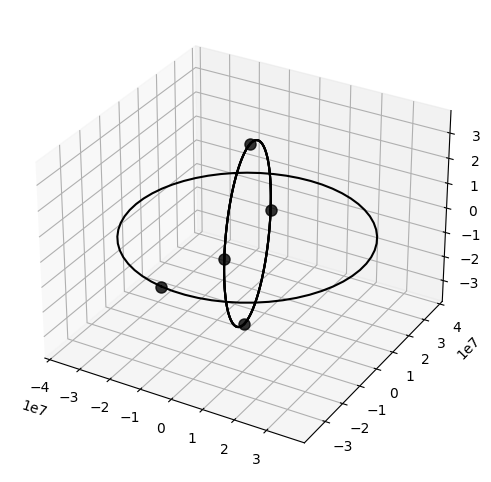

In [3]:
fig = plt.figure(figsize=(6,6),dpi=100)
ax = plt.axes(projection='3d')
for i in range (nPlanes*nSats):
    pk.orbit_plots.plot_planet(planet_list[i],axes=ax,s=64)
pk.orbit_plots.plot_planet(comms_sat[0],axes=ax,s=64)

Now we will create a PASEOS instance for each LEO satellite. Further, we add a communication device, power device and a thermal model.

Pleae have a look at the [readme sections on physical models](https://github.com/aidotse/PASEOS#physical-models) for additional details.

In [4]:
paseos_instances = [] # this will store paseos instances
earth = pk.planet.jpl_lp("earth") # define our central body

for idx,sat_pos_v in enumerate(sats_pos_and_v):
    pos,v = sat_pos_v
    sat_actor = ActorBuilder.get_actor_scaffold(name="Sat_"+str(idx),
                                                actor_type=SpacecraftActor,
                                                epoch=t0)
    ActorBuilder.set_orbit(actor=sat_actor,position=pos,velocity=v,epoch=t0,central_body=earth)
    ActorBuilder.add_comm_device(actor=sat_actor,device_name="Link1",bandwidth_in_kbps=1000)
    ActorBuilder.set_power_devices(actor=sat_actor,battery_level_in_Ws=50000,
                                   max_battery_level_in_Ws=100000,charging_rate_in_W=50)
    ActorBuilder.set_thermal_model(
            actor=sat_actor,
            actor_mass=50.0,
            actor_initial_temperature_in_K=273.15,
            actor_sun_absorptance=1.0,
            actor_infrared_absorptance=1.0,
            actor_sun_facing_area=1.0,
            actor_central_body_facing_area=1.0,
            actor_emissive_area=3.0,
            actor_thermal_capacity=1000
    )
    
    instance = paseos.init_sim(local_actor=sat_actor)
    paseos_instances.append(instance)

For our comms satellite, we skip modelling the thermal and power concerns for simplicity. Further, we add a groundstation on Gran Canaria.

In [5]:
comms_instances = []

gs_actor = ActorBuilder.get_actor_scaffold(name="gs_1",actor_type=GroundstationActor, epoch=t0)
ActorBuilder.set_ground_station_location(gs_actor,latitude=-15.6338, longitude=27.7629, elevation=205.1, minimum_altitude_angle=5)
instance = paseos.init_sim(local_actor=gs_actor)
comms_instances.append(instance)

pos,v = comm_sat_pos_and_v[0]
sat_actor = ActorBuilder.get_actor_scaffold(name="comms_1",actor_type=SpacecraftActor, epoch=t0)
ActorBuilder.set_orbit(actor=sat_actor,position=pos,velocity=v,epoch=t0,central_body=earth)
ActorBuilder.add_comm_device(actor=sat_actor,device_name="Link1",bandwidth_in_kbps=1000)    
instance = paseos.init_sim(local_actor=sat_actor)
comms_instances.append(instance)

We can use PASEOS internal plotting to have a look at our setup now. As of writing the plotting isn't ideal for larger constellations ¯\_(ツ)_/¯

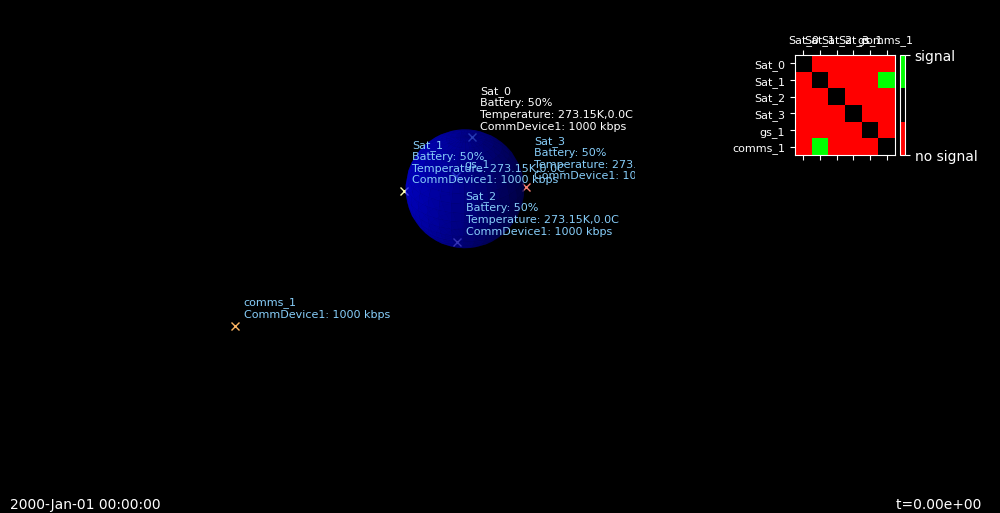

In [6]:
paseos_instances[0].emtpy_known_actors()
for instance in paseos_instances[1:]:
    paseos_instances[0].add_known_actor(instance.local_actor)
for instance in comms_instances:
    paseos_instances[0].add_known_actor(instance.local_actor)
plotter = paseos.plot(paseos_instances[0], paseos.PlotType.SpacePlot)

Now, we define some operational constraints for our constellation. Let's say, our LEO satellites have two tasks:

* Processing - Consumes 50W and can only be performed at < 68° C and if our battery is at least 20% charged.
* Charging - What we do if the above constraint is violated

To this end, we define a function hat returns `True` if the constraint is met.

In [7]:
def get_consumption_and_activity(actor):
    """Determine power consumption and activity for an actor."""
    if operational_constraint(actor):
        return 50.0,"Processing"
    else: 
        return 2.0, "Charging"

def operational_constraint(actor):
    """Determine if constraint is met for an actor"""
    if (actor.state_of_charge > 0.2 
        and actor.temperature_in_K < 350):
        return True
    else:
        return False

Now, we are ready to run the main simulation. We will simulate the operations of this constellation for 24 hours. Every 600 seconds (or once the constraint is no longer valid) we will redecide whether a satellite is going to "charge" or "process".

Whenever a satellite starts violating the operational constraint, it will stop the activity and continue which charging. This is marked by an `INFO` output from PASEOS.

N.B. technically, we should be advancing these satellites by the remainder of the 600 seconds in "charge" mode to sync them all up. This is skipped for comprehensibility.

In [8]:
simulation_time = 24.0 * 3600 # one day in seconds
t = 0 # starting time in seconds
timestep = 600 # refresh interval deciding which activity to perform

# Run until end of simulation
while t < simulation_time: 
    N_charging = 0 # track chargers
    N_processing = 0 # track processors
    # For each satellite, we perform the following steps
    for instance in paseos_instances:
        local_t = instance.local_actor.local_time
        # Update known actors, i.e. for each sat if they can
        # see the ground station and the comms satellite
        instance.emtpy_known_actors()
        for comm_instance in comms_instances:
            if instance.local_actor.is_in_line_of_sight(comm_instance.local_actor,epoch=local_t):
                instance.add_known_actor(comm_instance.local_actor)
        
        # Determine whether satellite is processing or charging
        power_consumption, activity = get_consumption_and_activity(instance.local_actor)
        if activity == "Processing":
            N_processing += 1
            eval_constraint = lambda: operational_constraint(instance.local_actor)
        else:
            N_charging += 1
            eval_constraint = None
        
        # This call is only necessary to display running activity 
        # in PASEOS internal monitoring (which we use below)
        instance.local_actor._current_activity = activity

        # Advance the simulation state of this satellite
        instance.advance_time(
            time_to_advance=timestep,
            current_power_consumption_in_W=power_consumption,
            constraint_function=eval_constraint
        )

    # Advance the comm satellite and ground station
    for instance in comms_instances:
        instance.advance_time(time_to_advance=timestep,current_power_consumption_in_W=0.0)

    print(f"Time:{t} - # of Processing = {N_processing}, # of Charging = {N_charging}")
    t += timestep

Time:0 - # of Processing = 4, # of Charging = 0


22:24:31|PASEOS-INFO| Actor: Sat_3 - Time advancing interrupted. Constraint false.


Time:600 - # of Processing = 3, # of Charging = 1
Time:1200 - # of Processing = 3, # of Charging = 1


22:24:33|PASEOS-INFO| Actor: Sat_2 - Time advancing interrupted. Constraint false.


Time:1800 - # of Processing = 3, # of Charging = 1
Time:2400 - # of Processing = 2, # of Charging = 2
Time:3000 - # of Processing = 3, # of Charging = 1


22:24:36|PASEOS-INFO| Actor: Sat_1 - Time advancing interrupted. Constraint false.
22:24:36|PASEOS-INFO| Actor: Sat_0 - Time advancing interrupted. Constraint false.


Time:3600 - # of Processing = 3, # of Charging = 1
Time:4200 - # of Processing = 3, # of Charging = 1
Time:4800 - # of Processing = 2, # of Charging = 2
Time:5400 - # of Processing = 2, # of Charging = 2


22:24:40|PASEOS-INFO| Actor: Sat_3 - Time advancing interrupted. Constraint false.


Time:6000 - # of Processing = 3, # of Charging = 1
Time:6600 - # of Processing = 2, # of Charging = 2


22:24:41|PASEOS-INFO| Actor: Sat_2 - Time advancing interrupted. Constraint false.


Time:7200 - # of Processing = 3, # of Charging = 1
Time:7800 - # of Processing = 2, # of Charging = 2
Time:8400 - # of Processing = 2, # of Charging = 2


22:24:44|PASEOS-INFO| Actor: Sat_1 - Time advancing interrupted. Constraint false.


Time:9000 - # of Processing = 3, # of Charging = 1


22:24:45|PASEOS-INFO| Actor: Sat_0 - Time advancing interrupted. Constraint false.


Time:9600 - # of Processing = 2, # of Charging = 2
Time:10200 - # of Processing = 3, # of Charging = 1
Time:10800 - # of Processing = 2, # of Charging = 2
Time:11400 - # of Processing = 2, # of Charging = 2


22:24:48|PASEOS-INFO| Actor: Sat_3 - Time advancing interrupted. Constraint false.


Time:12000 - # of Processing = 3, # of Charging = 1
Time:12600 - # of Processing = 3, # of Charging = 1


22:24:50|PASEOS-INFO| Actor: Sat_2 - Time advancing interrupted. Constraint false.


Time:13200 - # of Processing = 3, # of Charging = 1
Time:13800 - # of Processing = 2, # of Charging = 2
Time:14400 - # of Processing = 3, # of Charging = 1


22:24:53|PASEOS-INFO| Actor: Sat_1 - Time advancing interrupted. Constraint false.
22:24:53|PASEOS-INFO| Actor: Sat_0 - Time advancing interrupted. Constraint false.


Time:15000 - # of Processing = 3, # of Charging = 1
Time:15600 - # of Processing = 3, # of Charging = 1
Time:16200 - # of Processing = 2, # of Charging = 2
Time:16800 - # of Processing = 2, # of Charging = 2


22:24:58|PASEOS-INFO| Actor: Sat_3 - Time advancing interrupted. Constraint false.


Time:17400 - # of Processing = 3, # of Charging = 1
Time:18000 - # of Processing = 2, # of Charging = 2


22:24:59|PASEOS-INFO| Actor: Sat_2 - Time advancing interrupted. Constraint false.


Time:18600 - # of Processing = 3, # of Charging = 1
Time:19200 - # of Processing = 2, # of Charging = 2
Time:19800 - # of Processing = 2, # of Charging = 2


22:25:02|PASEOS-INFO| Actor: Sat_1 - Time advancing interrupted. Constraint false.


Time:20400 - # of Processing = 3, # of Charging = 1


22:25:03|PASEOS-INFO| Actor: Sat_0 - Time advancing interrupted. Constraint false.


Time:21000 - # of Processing = 2, # of Charging = 2
Time:21600 - # of Processing = 3, # of Charging = 1
Time:22200 - # of Processing = 2, # of Charging = 2
Time:22800 - # of Processing = 2, # of Charging = 2


22:25:07|PASEOS-INFO| Actor: Sat_3 - Time advancing interrupted. Constraint false.


Time:23400 - # of Processing = 3, # of Charging = 1
Time:24000 - # of Processing = 2, # of Charging = 2


22:25:08|PASEOS-INFO| Actor: Sat_2 - Time advancing interrupted. Constraint false.


Time:24600 - # of Processing = 3, # of Charging = 1
Time:25200 - # of Processing = 2, # of Charging = 2
Time:25800 - # of Processing = 3, # of Charging = 1


22:25:11|PASEOS-INFO| Actor: Sat_1 - Time advancing interrupted. Constraint false.


Time:26400 - # of Processing = 3, # of Charging = 1


22:25:13|PASEOS-INFO| Actor: Sat_0 - Time advancing interrupted. Constraint false.


Time:27000 - # of Processing = 3, # of Charging = 1
Time:27600 - # of Processing = 3, # of Charging = 1
Time:28200 - # of Processing = 2, # of Charging = 2


22:25:15|PASEOS-INFO| Actor: Sat_3 - Time advancing interrupted. Constraint false.


Time:28800 - # of Processing = 3, # of Charging = 1
Time:29400 - # of Processing = 2, # of Charging = 2


22:25:17|PASEOS-INFO| Actor: Sat_2 - Time advancing interrupted. Constraint false.


Time:30000 - # of Processing = 3, # of Charging = 1
Time:30600 - # of Processing = 2, # of Charging = 2
Time:31200 - # of Processing = 2, # of Charging = 2


22:25:20|PASEOS-INFO| Actor: Sat_1 - Time advancing interrupted. Constraint false.


Time:31800 - # of Processing = 3, # of Charging = 1


22:25:21|PASEOS-INFO| Actor: Sat_0 - Time advancing interrupted. Constraint false.


Time:32400 - # of Processing = 2, # of Charging = 2
Time:33000 - # of Processing = 3, # of Charging = 1
Time:33600 - # of Processing = 2, # of Charging = 2
Time:34200 - # of Processing = 2, # of Charging = 2


22:25:25|PASEOS-INFO| Actor: Sat_3 - Time advancing interrupted. Constraint false.


Time:34800 - # of Processing = 3, # of Charging = 1
Time:35400 - # of Processing = 2, # of Charging = 2


22:25:26|PASEOS-INFO| Actor: Sat_2 - Time advancing interrupted. Constraint false.


Time:36000 - # of Processing = 3, # of Charging = 1
Time:36600 - # of Processing = 2, # of Charging = 2
Time:37200 - # of Processing = 2, # of Charging = 2


22:25:29|PASEOS-INFO| Actor: Sat_1 - Time advancing interrupted. Constraint false.


Time:37800 - # of Processing = 3, # of Charging = 1


22:25:30|PASEOS-INFO| Actor: Sat_0 - Time advancing interrupted. Constraint false.


Time:38400 - # of Processing = 2, # of Charging = 2
Time:39000 - # of Processing = 3, # of Charging = 1
Time:39600 - # of Processing = 2, # of Charging = 2
Time:40200 - # of Processing = 2, # of Charging = 2


22:25:33|PASEOS-INFO| Actor: Sat_3 - Time advancing interrupted. Constraint false.


Time:40800 - # of Processing = 3, # of Charging = 1
Time:41400 - # of Processing = 3, # of Charging = 1


22:25:35|PASEOS-INFO| Actor: Sat_2 - Time advancing interrupted. Constraint false.


Time:42000 - # of Processing = 3, # of Charging = 1
Time:42600 - # of Processing = 2, # of Charging = 2
Time:43200 - # of Processing = 3, # of Charging = 1


22:25:38|PASEOS-INFO| Actor: Sat_1 - Time advancing interrupted. Constraint false.
22:25:39|PASEOS-INFO| Actor: Sat_0 - Time advancing interrupted. Constraint false.


Time:43800 - # of Processing = 3, # of Charging = 1
Time:44400 - # of Processing = 3, # of Charging = 1
Time:45000 - # of Processing = 2, # of Charging = 2
Time:45600 - # of Processing = 2, # of Charging = 2


22:25:43|PASEOS-INFO| Actor: Sat_3 - Time advancing interrupted. Constraint false.


Time:46200 - # of Processing = 3, # of Charging = 1
Time:46800 - # of Processing = 2, # of Charging = 2


22:25:44|PASEOS-INFO| Actor: Sat_2 - Time advancing interrupted. Constraint false.


Time:47400 - # of Processing = 3, # of Charging = 1
Time:48000 - # of Processing = 2, # of Charging = 2
Time:48600 - # of Processing = 2, # of Charging = 2


22:25:47|PASEOS-INFO| Actor: Sat_1 - Time advancing interrupted. Constraint false.


Time:49200 - # of Processing = 3, # of Charging = 1


22:25:49|PASEOS-INFO| Actor: Sat_0 - Time advancing interrupted. Constraint false.


Time:49800 - # of Processing = 2, # of Charging = 2
Time:50400 - # of Processing = 3, # of Charging = 1
Time:51000 - # of Processing = 2, # of Charging = 2
Time:51600 - # of Processing = 2, # of Charging = 2


22:25:52|PASEOS-INFO| Actor: Sat_3 - Time advancing interrupted. Constraint false.


Time:52200 - # of Processing = 3, # of Charging = 1
Time:52800 - # of Processing = 2, # of Charging = 2


22:25:54|PASEOS-INFO| Actor: Sat_2 - Time advancing interrupted. Constraint false.


Time:53400 - # of Processing = 3, # of Charging = 1
Time:54000 - # of Processing = 2, # of Charging = 2
Time:54600 - # of Processing = 2, # of Charging = 2


22:25:56|PASEOS-INFO| Actor: Sat_1 - Time advancing interrupted. Constraint false.


Time:55200 - # of Processing = 3, # of Charging = 1


22:25:58|PASEOS-INFO| Actor: Sat_0 - Time advancing interrupted. Constraint false.


Time:55800 - # of Processing = 2, # of Charging = 2
Time:56400 - # of Processing = 3, # of Charging = 1
Time:57000 - # of Processing = 2, # of Charging = 2
Time:57600 - # of Processing = 2, # of Charging = 2


22:26:01|PASEOS-INFO| Actor: Sat_3 - Time advancing interrupted. Constraint false.


Time:58200 - # of Processing = 3, # of Charging = 1
Time:58800 - # of Processing = 3, # of Charging = 1


22:26:03|PASEOS-INFO| Actor: Sat_2 - Time advancing interrupted. Constraint false.


Time:59400 - # of Processing = 3, # of Charging = 1
Time:60000 - # of Processing = 2, # of Charging = 2
Time:60600 - # of Processing = 3, # of Charging = 1


22:26:05|PASEOS-INFO| Actor: Sat_1 - Time advancing interrupted. Constraint false.
22:26:06|PASEOS-INFO| Actor: Sat_0 - Time advancing interrupted. Constraint false.


Time:61200 - # of Processing = 3, # of Charging = 1
Time:61800 - # of Processing = 3, # of Charging = 1
Time:62400 - # of Processing = 2, # of Charging = 2
Time:63000 - # of Processing = 2, # of Charging = 2


22:26:09|PASEOS-INFO| Actor: Sat_3 - Time advancing interrupted. Constraint false.


Time:63600 - # of Processing = 3, # of Charging = 1
Time:64200 - # of Processing = 2, # of Charging = 2


22:26:11|PASEOS-INFO| Actor: Sat_2 - Time advancing interrupted. Constraint false.


Time:64800 - # of Processing = 3, # of Charging = 1
Time:65400 - # of Processing = 2, # of Charging = 2
Time:66000 - # of Processing = 2, # of Charging = 2


22:26:14|PASEOS-INFO| Actor: Sat_1 - Time advancing interrupted. Constraint false.


Time:66600 - # of Processing = 3, # of Charging = 1


22:26:15|PASEOS-INFO| Actor: Sat_0 - Time advancing interrupted. Constraint false.


Time:67200 - # of Processing = 2, # of Charging = 2
Time:67800 - # of Processing = 3, # of Charging = 1
Time:68400 - # of Processing = 2, # of Charging = 2
Time:69000 - # of Processing = 2, # of Charging = 2


22:26:19|PASEOS-INFO| Actor: Sat_3 - Time advancing interrupted. Constraint false.


Time:69600 - # of Processing = 3, # of Charging = 1
Time:70200 - # of Processing = 3, # of Charging = 1


22:26:20|PASEOS-INFO| Actor: Sat_2 - Time advancing interrupted. Constraint false.


Time:70800 - # of Processing = 3, # of Charging = 1
Time:71400 - # of Processing = 2, # of Charging = 2
Time:72000 - # of Processing = 3, # of Charging = 1


22:26:23|PASEOS-INFO| Actor: Sat_1 - Time advancing interrupted. Constraint false.
22:26:24|PASEOS-INFO| Actor: Sat_0 - Time advancing interrupted. Constraint false.


Time:72600 - # of Processing = 3, # of Charging = 1
Time:73200 - # of Processing = 3, # of Charging = 1
Time:73800 - # of Processing = 2, # of Charging = 2
Time:74400 - # of Processing = 2, # of Charging = 2


22:26:27|PASEOS-INFO| Actor: Sat_3 - Time advancing interrupted. Constraint false.


Time:75000 - # of Processing = 3, # of Charging = 1
Time:75600 - # of Processing = 2, # of Charging = 2


22:26:29|PASEOS-INFO| Actor: Sat_2 - Time advancing interrupted. Constraint false.


Time:76200 - # of Processing = 3, # of Charging = 1
Time:76800 - # of Processing = 2, # of Charging = 2
Time:77400 - # of Processing = 2, # of Charging = 2


22:26:31|PASEOS-INFO| Actor: Sat_1 - Time advancing interrupted. Constraint false.


Time:78000 - # of Processing = 3, # of Charging = 1


22:26:33|PASEOS-INFO| Actor: Sat_0 - Time advancing interrupted. Constraint false.


Time:78600 - # of Processing = 2, # of Charging = 2
Time:79200 - # of Processing = 3, # of Charging = 1
Time:79800 - # of Processing = 2, # of Charging = 2
Time:80400 - # of Processing = 2, # of Charging = 2


22:26:37|PASEOS-INFO| Actor: Sat_3 - Time advancing interrupted. Constraint false.


Time:81000 - # of Processing = 3, # of Charging = 1
Time:81600 - # of Processing = 2, # of Charging = 2


22:26:38|PASEOS-INFO| Actor: Sat_2 - Time advancing interrupted. Constraint false.


Time:82200 - # of Processing = 3, # of Charging = 1
Time:82800 - # of Processing = 2, # of Charging = 2
Time:83400 - # of Processing = 2, # of Charging = 2


22:26:41|PASEOS-INFO| Actor: Sat_1 - Time advancing interrupted. Constraint false.


Time:84000 - # of Processing = 3, # of Charging = 1


22:26:43|PASEOS-INFO| Actor: Sat_0 - Time advancing interrupted. Constraint false.


Time:84600 - # of Processing = 2, # of Charging = 2
Time:85200 - # of Processing = 3, # of Charging = 1
Time:85800 - # of Processing = 2, # of Charging = 2


Alright! Now, let's have a look at what actually happened during our simulation.

For this, we will make use of [PASEOS' monitor](https://github.com/aidotse/PASEOS#monitor).

The below code uses it to extract a few quantities for all our sats and plots them over the course of the simulation.

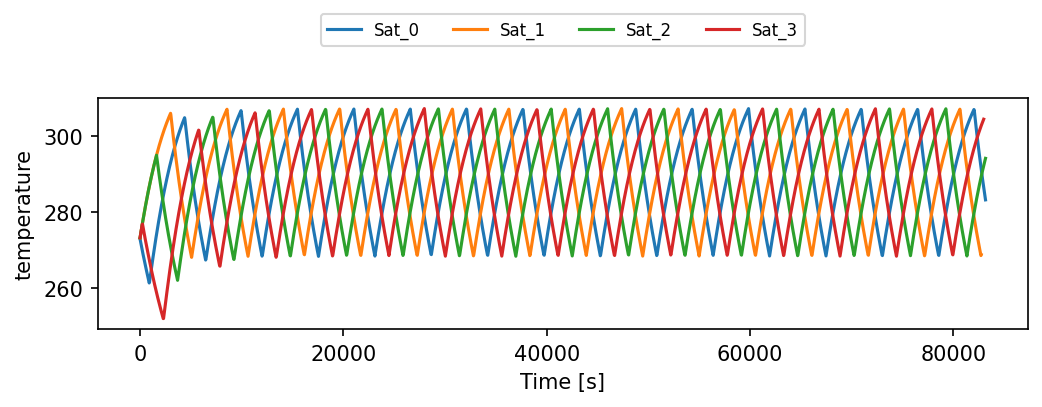

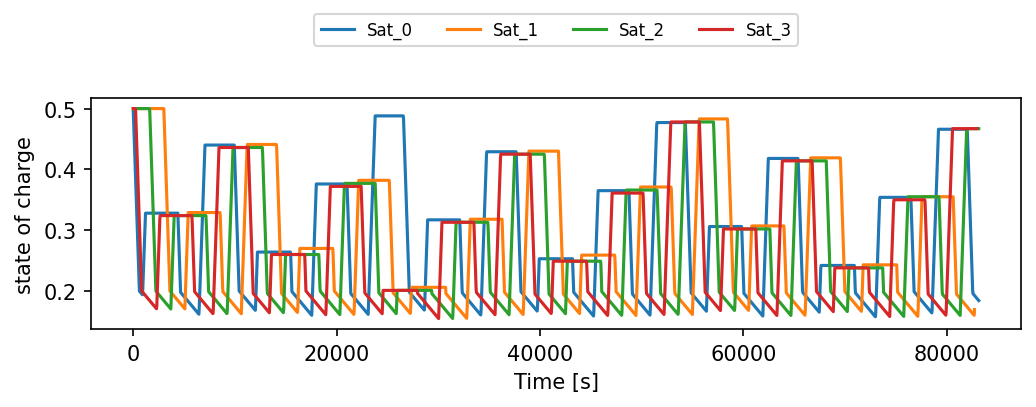

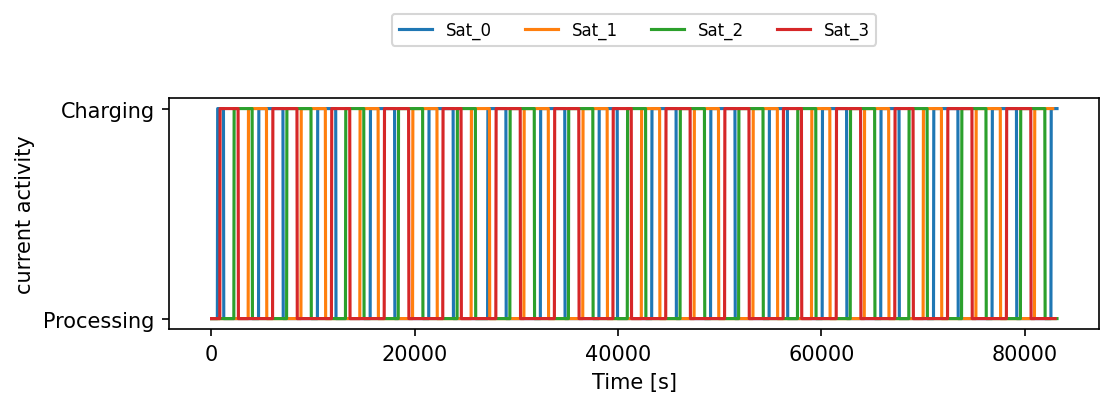

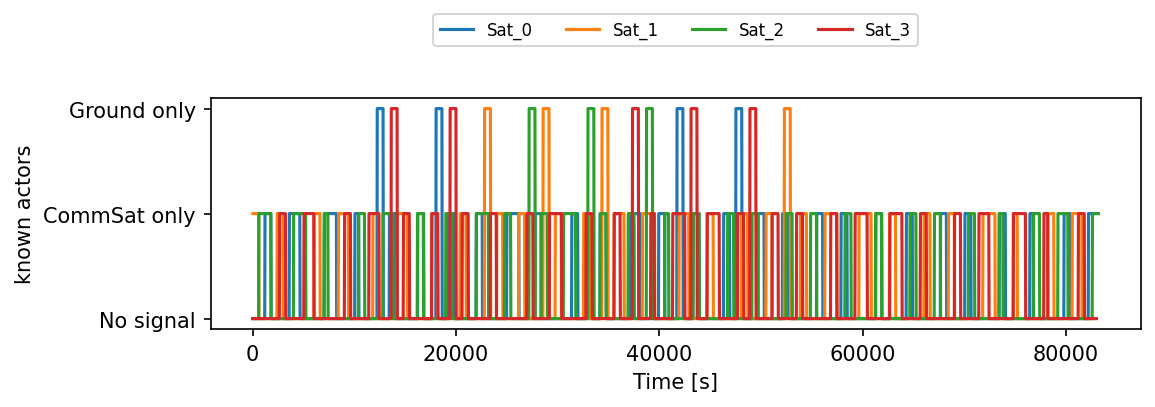

In [9]:
def convert_known_actors_to_categorical(values):
    """Helper function to track comms status"""
    conv_values = []
    for val in values:
        status = ["No signal", "Ground only", "CommSat only", "Ground + Sat"]
        idx = ("comms_1" in val) * 2 + 1*("gs_1" in val)
        conv_values.append(status[idx])
    return conv_values

# Quantities we wanna track
quantities = ["temperature","state_of_charge","current_activity","known_actors"]
for item in quantities:
    names = []

    plt.figure(figsize=(8, 2),dpi=150)

    # Get dat afrom all satellites and plot it
    for instance in paseos_instances:

        # Get time of each data point
        timesteps = instance.monitor["timesteps"]

        # Get data
        if item == "known_actors":
            values = convert_known_actors_to_categorical(instance.monitor[item])
        else:
            values = instance.monitor[item]
        names.append(instance.local_actor.name)

        # Plot it :)
        plt.plot(timesteps,values)
        plt.xlabel("Time [s]")
        plt.ylabel(item.replace("_", " "))

    # Add a legend showing which satellite is which
    plt.legend(
            names,
            fontsize = 8,
            bbox_to_anchor=(0.5, 1.4),
            ncol=10,
            loc="upper center",
    )
